In [131]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import Yukawa_SINDy as ys
import pysindy as ps
from importlib import reload

In [ ]:
# included to update Yukawa_SINDy.py version used in this notebook as changes are made
reload(ys)

In [156]:
plt.rcParams['axes.autolimit_mode'] = 'data'
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)

In [154]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'b

# Analysis of Yukawa 2-body data using Weak SINDy

The purpose of this notebook is to use a weak SINDy analysis on 2-body trajectories to see if the sparse recovery of simulation coefficients is improved. Results from the analysis of the same system using only one trajectory with strong-form SINDy (the original formulation) is shown in the notebook 'Yukawa2body.ipynb'.

Here, we will start by using one trajectory of the 2-body equations, as we did before, and then possibly extend to more trajectories.

## `std_dev=0.01`

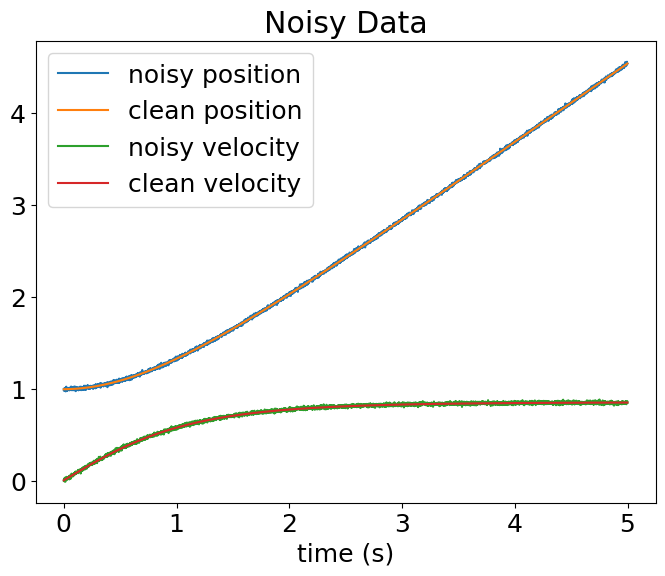

In [157]:
sim = ys.Yukawa_simulation()
sim.simulate(5)
sim.add_gaussian_noise(noise_level=0.01)
sim.plot()

In [134]:
# define lambdas for library functions
library_functions = [
    # lambda x: 1.0, get rid of this term because it is being duplicated and causing an error
    lambda x: x,
    lambda x: np.exp(-x) / x,
    lambda x: np.exp(-x) / x**2,
    lambda x: np.exp(-x) / x**3,
    lambda x: np.exp(-x) / x**4,
]

# define names for library functions
library_function_names = [
    # lambda x: 1,
    lambda x: x,
    lambda x: "exp(-" + x + ") / " + x,
    lambda x: "exp(-" + x + ") / " + x + "^2",
    lambda x: "exp(-" + x + ") / " + x + "^3",
    lambda x: "exp(-" + x + ") / " + x + "^4",
]

# generate weak form library
weak_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    spatiotemporal_grid=sim.t,
    function_names=library_function_names,
    is_uniform=True)

# generate strong form library
strong_lib = ps.CustomLibrary(
    library_functions=library_functions, 
    function_names=library_function_names)

In [147]:
def scan_thresholds(thresholds, verbose=False):
    complexities = np.empty((2,0))
    precision = 5
    for thresh in thresholds:
        opt = ps.STLSQ(threshold=thresh)
        # fit weak model
        weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
        weak_model.fit(sim.x, t=sim.dt)
        if verbose:
            print("STLSQ threshold:", thresh)
            print("\nWeak model")
            weak_model.print(precision=precision)
        weak_complexity = weak_model.complexity
        # fit strong model
        strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
        strong_model.fit(sim.x, t=sim.dt)
        if verbose:
            print("\nStrong model")
            strong_model.print(precision=precision)
            print("\n" + 100*"=" + "\n")
        strong_complexity = strong_model.complexity

        new_complexities = np.array([weak_complexity, strong_complexity]).reshape((2,1))
        complexities = np.append(complexities, new_complexities, axis=1)
        
    return complexities


In [148]:
thresholds = np.arange(0, 0.2, 0.01)
complexities = scan_thresholds(thresholds, verbose=True)

STLSQ threshold: 0.0

Weak model
(x)' = 0.03688 x + -1.23586 v + 6.60972 exp(-x) / x + 5.24205 exp(-v) / v + -45.58698 exp(-x) / x^2 + -1.71635 exp(-v) / v^2 + 61.34524 exp(-x) / x^3 + 0.23476 exp(-v) / v^3 + -35.02262 exp(-x) / x^4 + -0.01138 exp(-v) / v^4
(v)' = 0.02413 x + -0.61980 v + 9.32129 exp(-x) / x + 1.17114 exp(-v) / v + -35.91971 exp(-x) / x^2 + -0.32216 exp(-v) / v^2 + 50.18031 exp(-x) / x^3 + 0.04065 exp(-v) / v^3 + -25.39832 exp(-x) / x^4 + -0.00201 exp(-v) / v^4

Strong model
(x)' = 0.26790 x + -0.39245 v + 69.10195 exp(-x) / x + -0.02851 exp(-v) / v + -214.72287 exp(-x) / x^2 + 0.00006 exp(-v) / v^2 + 231.54884 exp(-x) / x^3 + -85.56737 exp(-x) / x^4
(v)' = 0.19802 x + -1.09564 v + 75.12495 exp(-x) / x + -0.00774 exp(-v) / v + -253.10291 exp(-x) / x^2 + 0.00010 exp(-v) / v^2 + 301.64100 exp(-x) / x^3 + -121.92061 exp(-x) / x^4


STLSQ threshold: 0.01

Weak model
(x)' = 0.00593 x + 1.01441 v + 0.67346 exp(-x) / x + -0.09173 exp(-v) / v + 0.00954 exp(-v) / v^2 + -2.31207

c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.16) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.17) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.17) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.18) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\envs\yukawa-project\Lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.18) and eliminated all coefficients
  warnings.warn(
c:\Users\zacha\anaconda3\

In [165]:
opt = ps.STLSQ(threshold=0.04)
weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
weak_model.fit(sim.x)
weak_model.print(precision=2)

(x)' = 1.00 v
(v)' = 0.99 exp(-x) / x + 1.01 exp(-x) / x^2


In [137]:
def plot_complexities(thresholds, complexities):
    fig, ax = plt.subplots(1,1)
    labels = ["Weak model", "Strong model"]
    for i in range (2):
        ax.plot(thresholds, complexities[i], 'o', label=labels[i])
    ax.hlines(3, min(thresholds), max(thresholds),linestyles='dashed', lw=1.5, label="Simulation Equations")
    ax.set_ylim(0, None)
    ax.yaxis.set_major_locator(MultipleLocator(base=2))
    ax.legend()
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Number of terms")
    ax.set_title("Noise level: " + str(np.round(sim.noise_level, 2)))
    fig.tight_layout()
    return fig, ax

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

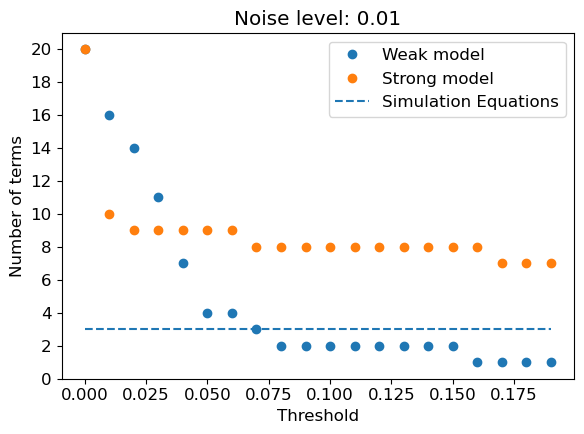

In [161]:
plt.rcParams["figure.figsize"] = (6,4.5)
plt.rcParams["font.size"] = 12
plot_complexities(thresholds, complexities)

In [163]:
thresholds = np.arange(0.04, 0.05, 0.001)
complexities = scan_thresholds(thresholds, verbose=True)

STLSQ threshold: 0.04

Weak model
(x)' = -0.00069 x + 0.99841 v + 0.00450 exp(-v) / v + -0.00142 exp(-v) / v^2
(v)' = 0.98843 exp(-x) / x + 0.00006 exp(-v) / v + 1.00668 exp(-x) / x^2

Strong model
(x)' = 0.97179 v + 10.28712 exp(-x) / x + -42.54660 exp(-x) / x^2 + 58.46354 exp(-x) / x^3 + -26.45565 exp(-x) / x^4
(v)' = 2.81006 exp(-x) / x + -7.02146 exp(-x) / x^2 + 11.00022 exp(-x) / x^3 + -4.70949 exp(-x) / x^4


STLSQ threshold: 0.041

Weak model
(x)' = -0.00069 x + 0.99841 v + 0.00450 exp(-v) / v + -0.00142 exp(-v) / v^2
(v)' = 0.98843 exp(-x) / x + 0.00006 exp(-v) / v + 1.00668 exp(-x) / x^2

Strong model
(x)' = 0.97179 v + 10.28712 exp(-x) / x + -42.54660 exp(-x) / x^2 + 58.46354 exp(-x) / x^3 + -26.45565 exp(-x) / x^4
(v)' = 2.81006 exp(-x) / x + -7.02146 exp(-x) / x^2 + 11.00022 exp(-x) / x^3 + -4.70949 exp(-x) / x^4


STLSQ threshold: 0.042

Weak model
(x)' = -0.00069 x + 0.99841 v + 0.00450 exp(-v) / v + -0.00142 exp(-v) / v^2
(v)' = 0.98843 exp(-x) / x + 0.00006 exp(-v) / v 

(<Figure size 600x450 with 1 Axes>,
 <Axes: title={'center': 'Noise level: 0.01'}, xlabel='Threshold', ylabel='Number of terms'>)

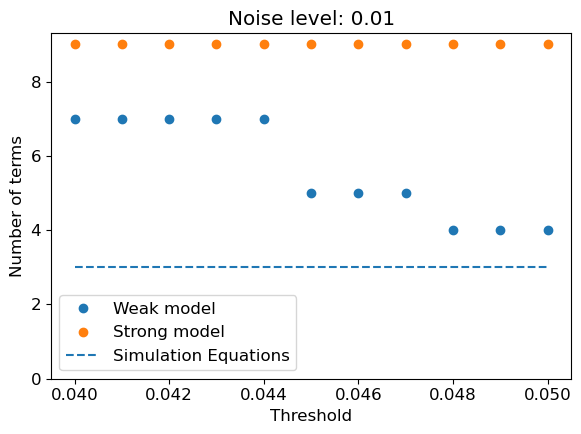

In [164]:
plot_complexities(thresholds, complexities)

In [53]:
thresholds = np.arange(0.04, 0.05, 0.001)
for thresh in thresholds:
    opt = ps.STLSQ(threshold=thresh)
    # fit weak model
    weak_model = ps.SINDy(feature_names=["x", "v"],feature_library=weak_lib, optimizer=opt)
    weak_model.fit(sim.x, t=sim.dt)
    print("STLSQ threshold:", thresh)
    print("\nWeak model")
    weak_model.print()

    # # fit strong model
    # strong_model = ps.SINDy(feature_names=["x", "v"],feature_library=strong_lib, optimizer=opt)
    # strong_model.fit(sim.x, t=sim.dt)
    # print("\nStrong model")
    # strong_model.print()
    
    print("\n" + 100*"=" + "\n")


STLSQ threshold: 0.04

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.020 exp(-x) / x + -0.001 exp(-v) / v + 0.979 exp(-x) / x^2


STLSQ threshold: 0.041

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.020 exp(-x) / x + -0.001 exp(-v) / v + 0.979 exp(-x) / x^2


STLSQ threshold: 0.042

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.020 exp(-x) / x + -0.001 exp(-v) / v + 0.979 exp(-x) / x^2


STLSQ threshold: 0.043000000000000003

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.770 exp(-x) / x + -0.039 exp(-v) / v + 0.018 exp(-v) / v^2


STLSQ threshold: 0.044000000000000004

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.770 exp(-x) / x + -0.039 exp(-v) / v + 0.018 exp(-v) / v^2


STLSQ threshold: 0.045000000000000005

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.770 exp(-x) / x + -0.039 exp(-v) / v + 0.018 exp(-v) / v^2


STLSQ threshold: 0.046000000000000006

Weak model
(x)' = 1.001 v + -0.001 exp(-v) / v
(v)' = 1.847 exp(-x) / x

SINDy goes ahead and discovers extraneous terms, dependent ONLY upon the unphysical velocity terms. This is similar to how it behaved with the three-body system, which is very curious.